In [1]:
labeled_objects = [{'object_name': 'bowl', 'start_frame': 145, 'end_frame': 171},
 {'object_name': 'bowl', 'start_frame': 32, 'end_frame': 73},
 {'object_name': 'plate', 'start_frame': 119, 'end_frame': None},
 {'object_name': 'plate', 'start_frame': 107, 'end_frame': 128},
 {'object_name': 'chopstick', 'start_frame': 339, 'end_frame': 353},
 {'object_name': 'plastic bottle', 'start_frame': 257, 'end_frame': None},
 {'object_name': 'spoon', 'start_frame': 230, 'end_frame': 247},
 {'object_name': 'foil packet', 'start_frame': 261, 'end_frame': 319},
 {'object_name': 'cardboard food container',
  'start_frame': None,
  'end_frame': None},
 {'object_name': 'cardboard food container',
  'start_frame': 77,
  'end_frame': 88}]

In [2]:
filtered_objects = [obj for obj in labeled_objects if obj['start_frame'] is not None and obj['end_frame'] is not None]

In [3]:
filtered_objects

[{'object_name': 'bowl', 'start_frame': 145, 'end_frame': 171},
 {'object_name': 'bowl', 'start_frame': 32, 'end_frame': 73},
 {'object_name': 'plate', 'start_frame': 107, 'end_frame': 128},
 {'object_name': 'chopstick', 'start_frame': 339, 'end_frame': 353},
 {'object_name': 'spoon', 'start_frame': 230, 'end_frame': 247},
 {'object_name': 'foil packet', 'start_frame': 261, 'end_frame': 319},
 {'object_name': 'cardboard food container',
  'start_frame': 77,
  'end_frame': 88}]

In [4]:
import json
import asyncio
from openai import AsyncOpenAI
import os
import cv2
import base64
import re

from config import OPENAI_API_KEY, VIDEO_PATH, MODEL
from video_labeling.prompts.shared import SYSTEM_PROMPT
from video_labeling.prompts.label_actions import LABEL_ACTIONS

## Action and time step labeling  

In [5]:
client = AsyncOpenAI(api_key=OPENAI_API_KEY)

In [6]:
def get_total_frames(video_path):
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    video.release()
    return total_frames

total_frames = get_total_frames(VIDEO_PATH)
print(f"Total frames in the video: {total_frames}")

Total frames in the video: 1116


In [7]:
## extract the frames for each object
def extract_frames_from_video(video_path, start_frame, end_frame, fps=10):
    base64Frames = []
    video = cv2.VideoCapture(video_path)
    video_fps = video.get(cv2.CAP_PROP_FPS)

    frames_to_skip = max(int(video_fps / fps), 1)
    curr_frame = start_frame

    while curr_frame < end_frame:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip

    video.release()

    return base64Frames

In [8]:
example = filtered_objects[5]
start_frame, end_frame = example['start_frame']*3, example['end_frame']*3
# increase the window by 2 seconds on either side. 
start_frame -= 60
end_frame += 30
fps =3

frames = extract_frames_from_video(VIDEO_PATH, start_frame, end_frame, fps=fps)
print(len(frames))

27


In [9]:
def extract_json_from_response(response):
    try:
        match = re.search(r"\{.*\}", response, re.DOTALL)
        if match:
            return json.loads(match.group(0))
        else:
            print("No JSON object found in the response")
            print(response)
            return None
    except Exception as e:
        print(f"Error decoding JSON or accessing response: {e}")
        return None

In [10]:
MODEL = 'gpt-4o'
# MODEL = 'gpt-4o-2024-08-06'


In [11]:
async def vlm_request(
    client, system_prompt, prompt, frames, temperature=0, extract_json=True
):

    messages = [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                "These are a sequence of images from the video. The first image is the start image, and the final image is the end image.",
                *map(
                    lambda x: {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpg;base64,{x}",
                            "detail": "high",
                        },
                    },
                    frames,
                ),
                prompt,
            ],
        },
    ]

    response = await client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=temperature,
    )

    response = response.choices[0].message.content

    if extract_json:
        response = extract_json_from_response(response)

    return response

In [12]:
LABEL_ACTIONS_FIRST_PASS = """
**Objective:**
Determine and report the actions and frame numbers successfully completed by a robot in a video sequence involving object {object}. 

**Summary Criteria:**
- There are two actions the robot will complete in this video: "pick up" and "put". Your job is to determine when the start and end frame for both actions is based on a set of criteria below.
- Ensure each reported action matches the visual evidence available in the video.
- Think carefully what the destination is, and follow the object destination rules above.

**High-Level Summary Instructions:**
Provide a summary of each action (Pick up and Put) that has been completed throughout the video. Specify the object involved and its final destination if applicable. Use the following example to guide your report:

**Example Summary Report in JSON Format:**
{{
  "tasks": [
    {{
      "action": "Pick up Bowl",
      "details": "Bowl clearly in the robot gripper, has been picked up from the table and is clearly suspended in the air.",
      "start_image": 2,
      "end_image": 7,
      "object": "Bowl"
    }},
    {{
      "action": "Put Bowl into container",
      "details": "After picking up, the bowl is observed being placed into the plastic box. The action is confirmed complete as the robot's gripper retracts and the bowl is no longer in contact with the gripper.",
      "start_image": 7,
      "end_image": 10,
      "object": "Bowl"
    }}
  ]
}}

Think step by step through this problem and adhere precisely to the instructions. 
"""

In [13]:
LABEL_ACTIONS = """
**Objective:**
Determine and report the actions and frame numbers successfully completed by a robot in a video sequence involving object {object}. 

**Summary Criteria:**
- There are two actions the robot will complete in this video: "pick up" and "put". Your job is to determine when the start and end frame for both actions is based on a set of criteria below.
- Ensure each reported action matches the visual evidence available in the video.
- Think carefully what the destination is, and follow the object destination rules above.

**High-Level Summary Instructions:**
Provide a summary of each action (Pick up and Put) that has been completed throughout the video. Specify the object involved and its final destination if applicable. Use the following example to guide your report:

**Instructions for Pick up:**

**1. Start Image Criteria for Pickup:**
   - **Criterion 1:** The gripper is empty and far away from any object. It is crucial that it is not holding any object, even previous ones. 
   - **Criterion 2:** This frame should be before any approach towards {object} is visible
   - **Criterion 3:** The gripper should be positioned away from any objects, and the following frames should capture the robot gripper moving towards the `{object}`, before it picks it up. 

**2. End Image Criteria for Pickup:**
   - **Criterion 1:** Identify the image where `{object}` is securely held by the gripper and fully lifted off the table. If `{object}` is still touching the table, select a subsequent frame.
   - **Criterion 2:** There are at least a couple of frames showing {object} off the table
   - **Criterion 3:** The `{object}` should not be over the container / bin yet.
   

**Instructions for Put:**

**1. Start Image Criteria for Put:**
   - **Criterion 1:** Identify the image where the robot’s gripper is securely holding `{object}`, which should be elevated and not yet positioned over its final destination. If `{object}` is already positioned over the destination, select an earlier frame as the start.
   - **Criterion 2:** The gripper should be actively moving towards the destination, having just completed the pickup phase. Images where the gripper is stationary or moving away from the destination are considered too late.
   - **Criterion 3:** `{object}` must be clearly lifted off the table, ensuring visible space between the table and the object.

**2. End Image Criteria for Put:**
   - **Criterion 1:** Locate the image where the gripper has released `{object}` into its designated spot, and the object is visibly settled within the destination. If `{object}` has not been released, the frame is too early.
   - **Criterion 2:** Confirm the presence of preceding images showing `{object}` already in the destination to ensure continuity. Lack of such frames suggests the need for additional footage.
   - **Criterion 3:** Search for images showing a clear retreat of the gripper from the destination. Images where the gripper remains in contact with `{object}` are too early.
 
   
**Example Summary Report in JSON Format:**
{{
  "tasks": [
    {{
      "action": "Pick up Bowl",
      "details": "Bowl clearly in the robot gripper, has been picked up from the table and is clearly suspended in the air.",
      "start_image": 2,
      "end_image": 7,
      "object": "Bowl"
    }},
    {{
      "action": "Put Bowl into container",
      "details": "After picking up, the bowl is observed being placed into the plastic box. The action is confirmed complete as the robot's gripper retracts and the bowl is no longer in contact with the gripper.",
      "start_image": 7,
      "end_image": 10,
      "object": "Bowl"
    }}
  ]
}}

Think step by step through this problem and adhere precisely to the instructions. Remember, you are analyzing {num_frames} frames in total.
"""

In [14]:
def adjust_fps_to_frame_count(
    video_path, segment_start, segment_end, initial_fps, min_frames, max_frames
):
    """
    Adjust the frames per second (fps) to ensure the number of frames lies within a specified range.
    """
    sequence_fps = initial_fps
    fps_options = [1,2,3, 5, 10]
    while True:
        frames = extract_frames_from_video(
            video_path,
            start_frame=segment_start,
            end_frame=segment_end,
            fps=sequence_fps,
        )
        num_images = len(frames)

        if num_images < min_frames:
            # Increase fps to the next higher option if below the minimum frame count
            current_index = fps_options.index(sequence_fps)
            if current_index < len(fps_options) - 1:
                sequence_fps = fps_options[current_index + 1]
            else:
                # If already at max fps and frames are still not enough, use the highest possible fps
                break
        elif num_images > max_frames:
            # Decrease fps to the next lower option if above the maximum frame count
            current_index = fps_options.index(sequence_fps)
            if current_index > 0:
                sequence_fps = fps_options[current_index - 1]
            else:
                # If already at minimum fps and frames are still too many, use the lowest possible fps
                break
        else:
            # If the number of frames is within the acceptable range, stop adjusting
            break

    return frames, sequence_fps


In [23]:
import time
from PIL import Image

def render_video(frames, render_frame=-1):     
    display_handle = display(None, display_id=True)
    for idx, img in enumerate(frames):  
        if idx==render_frame: 
            display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
            time.sleep(0.1)
            break
        else:    
            display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
            time.sleep(0.1)

In [24]:

async def process_object(obj):
    start_frame, end_frame = obj['start_frame']*3, obj['end_frame']*3
    start_frame -= 60
    end_frame += 30
    fps = 3

    frames, _ = adjust_fps_to_frame_count(
        VIDEO_PATH, start_frame, end_frame, fps, 8, 22
    )
    num_frames = len(frames)

    # frames = extract_frames_from_video(VIDEO_PATH, start_frame, end_frame, fps=fps)
    print(f"object {obj['object_name']} has this many frames: {len(frames)}")
    
    label_action_prompt = LABEL_ACTIONS.format(object=obj['object_name'], num_frames=num_frames)
    answer = await vlm_request(client, SYSTEM_PROMPT, label_action_prompt, frames, extract_json=True)
    
    pick_up_start_image = answer['tasks'][0]['start_image']
    pick_up_end_image = answer['tasks'][0]['end_image']
    put_start_image = answer['tasks'][1]['start_image']
    put_end_image = answer['tasks'][1]['end_image']

    pickup_start_frame = int(start_frame) + (pick_up_start_image - 1) * 30 / fps
    pickup_end_frame = int(start_frame) + (pick_up_end_image) * 30 / fps
    put_start_frame = int(start_frame) + (put_start_image - 1) * 30 / fps
    put_end_frame = int(start_frame) + (put_end_image) * 30 / fps
    
    answer['tasks'][0]['start_frame'] = pickup_start_frame
    answer['tasks'][0]['end_frame'] = pickup_end_frame
    answer['tasks'][1]['start_frame'] = put_start_frame
    answer['tasks'][1]['end_frame'] = put_end_frame
    
    return answer

In [25]:
tasks = [process_object(obj) for obj in filtered_objects]
response = await asyncio.gather(*tasks)



object bowl has this many frames: 17
object bowl has this many frames: 22
object plate has this many frames: 16
object chopstick has this many frames: 14
object spoon has this many frames: 15
object foil packet has this many frames: 18
object cardboard food container has this many frames: 13


In [26]:
response

[{'tasks': [{'action': 'Pick up Bowl',
    'details': 'Bowl clearly in the robot gripper, has been picked up from the table and is clearly suspended in the air.',
    'start_image': 1,
    'end_image': 8,
    'object': 'Bowl',
    'start_frame': 375.0,
    'end_frame': 455.0},
   {'action': 'Put Bowl into container',
    'details': "After picking up, the bowl is observed being placed into the plastic box. The action is confirmed complete as the robot's gripper retracts and the bowl is no longer in contact with the gripper.",
    'start_image': 8,
    'end_image': 13,
    'object': 'Bowl',
    'start_frame': 445.0,
    'end_frame': 505.0}]},
 {'tasks': [{'action': 'Pick up Bowl',
    'details': 'The robot gripper approaches and securely grasps the bowl, lifting it off the table.',
    'start_image': 1,
    'end_image': 8,
    'object': 'Bowl',
    'start_frame': 36.0,
    'end_frame': 116.0},
   {'action': 'Put Bowl into container',
    'details': 'The robot gripper moves the bowl over 

In [39]:
index = 0
answer = response[index]

In [40]:
answer

{'tasks': [{'action': 'Pick up Bowl',
   'details': 'Bowl clearly in the robot gripper, has been picked up from the table and is clearly suspended in the air.',
   'start_image': 1,
   'end_image': 8,
   'object': 'Bowl',
   'start_frame': 375.0,
   'end_frame': 455.0},
  {'action': 'Put Bowl into container',
   'details': "After picking up, the bowl is observed being placed into the plastic box. The action is confirmed complete as the robot's gripper retracts and the bowl is no longer in contact with the gripper.",
   'start_image': 8,
   'end_image': 13,
   'object': 'Bowl',
   'start_frame': 445.0,
   'end_frame': 505.0}]}

In [41]:

pick_up_frames = extract_frames_from_video(VIDEO_PATH, answer['tasks'][0]['start_frame'], answer['tasks'][0]['end_frame'], fps=30)
put_frames = extract_frames_from_video(VIDEO_PATH, answer['tasks'][1]['start_frame'], answer['tasks'][1]['end_frame'], fps=30)

In [42]:
from PIL import Image
from IPython.display import display, Image as IPImage

def render_video(frames, render_frame=-1):     
    display_handle = display(None, display_id=True)
    for idx, img in enumerate(frames):  
        if idx == render_frame: 
            display_handle.update(IPImage(data=base64.b64decode(img.encode("utf-8")), width=600))
            time.sleep(0.1)
            break
        else:    
            display_handle.update(IPImage(data=base64.b64decode(img.encode("utf-8")), width=600))
            time.sleep(0.1)

In [43]:
len(pick_up_frames)

80

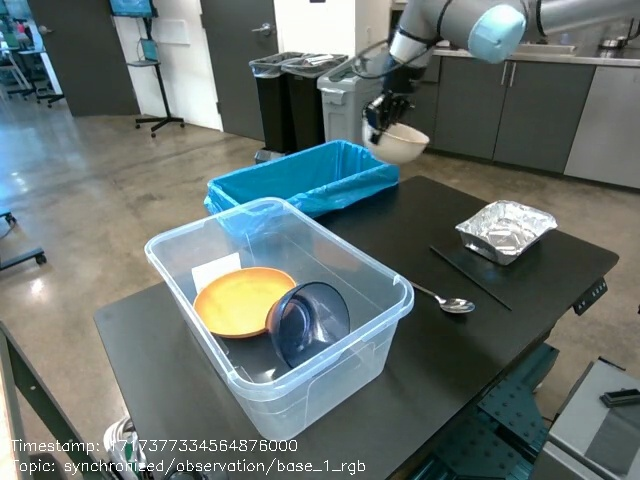

In [44]:
render_video(pick_up_frames)

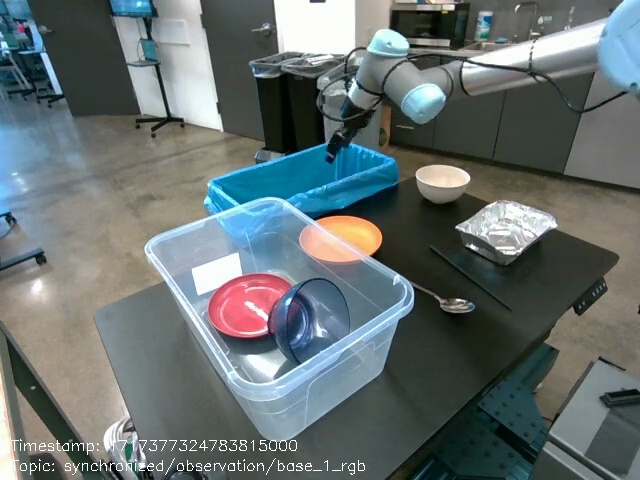

In [38]:
render_video(put_frames)

In [ ]:
x=3

## Ok - now lets run the reflection module 

In [199]:
CHECK_PICKUP_START_IMAGE_TIMING = """
### Analyze the Robot's Pickup Action: {action}

**Context:**
You are tasked to analyze a sequence where a robot attempts to pick up {object}. The primary goal is to verify if the first image completely encapsulates the criteria for a successful start of the pickup action.

**Helpful Information:**
- If an object is no longer visible on the table and is not in the robot's gripper, it implies it has been deposited at the destination.
- The chopstick, if applicable, is often hard to see when grasped. Pay special attention if the object is a chopstick.

**Initial Check:**
- **Check 1:** Determine if the first object the robot holds in its gripper is {object}. If the robot is seen holding an object other than {object} in three consecutive images, respond with "wrong_object". 
The reason for having 3 consecutive images is that it prevents false positives like knocking over another object. To be the wrong_object, a different object than {object} needs to be in the roobot gripper for 3 seperate images. This check precedes any other analysis.

**Detailed Criteria for Pickup:**

**1. Start Image Criteria for Pickup:**
   - **Criterion 1:** The robot's gripper should not be holding any objects, including {object}.
   - **Criterion 2:** The robot's gripper should be positioned to soon pick up {object}, with visible space between the gripper and the object.
   - **Criterion 3:** The gripper should be positioned away from any objects, with subsequent frames showing the gripper moving towards {object} before picking it up.

**2. End Image Criteria for Pickup:**
   - **Criterion 1:** Identify the frame where {object} is securely held by the gripper and fully lifted off the table. If {object} is still touching the table, choose a later frame.
   - **Criterion 2:** Ensure that {object} has not started moving towards any destination like a bin or container. It should be just picked up, not yet moving towards the destination.
   - **Criterion 3:** The {object} should be firmly in the grasp of the robot. It should be above the table, and not close yet to the bin/container. If so, the image is too late.

**Instruction:**
- First, evaluate if the robot initially holds {object} in its gripper. If the first object held is not {object} and this is shown in three consecutive images, return "wrong_object". It is important for it to be shown in three consecutive images to avoid false positives.
- Next, evaluate if the first image strictly satisfies the criteria for the START image of this action {action}. Focus solely on the first image.

**Expected Response:**
- If the first object held in the gripper is not {object}, return "wrong_object".
- Otherwise, after reasoning about the answer based on the start image criteria, return a JSON indicating whether the START image for this action is "perfect", "early", or "late".

**Example Response:**
[Reasoning]
```json
{{
  "answer": "perfect"  // Options are "perfect", "early", "late", or "wrong_object"
}}
"""

CHECK_PICKUP_END_IMAGE_TIMING = """
### Analyze the Robot's Pickup Action: {action}

**Context:**
You are assigned to analyze a sequence in which a robot attempts to pick up {object}. The aim is to verify this if the final image FULLY encapsulates the criteria.

**Helpful information:**: 
To check if an object is grasped, check if the robot grippers are holding anything. 
If an object is no longer visible on the table, and is not in the robot's gripper, it means it has been deposited in the destination.
The chopstick is often hard to see, especially when grasped. Please pay special attention if the object is the chopstick.

**1. Start Image Criteria for Pickup:**
   - **Criterion 1:** The robot gripper should not be grasping or holding any objects, including `{object}`
   - **Criterion 2:** The robot gripper should be about to pick up `{object}`, but has some space in between the gripper and the object.
   - **Criterion 3:** The gripper should be positioned away from any objects, and the following frames should capture the robot gripper moving towards the `{object}`, before it picks it up. 

**2. End Image Criteria for Pickup:**
   - **Criterion 1:** Identify the image where `{object}` is securely held by the gripper and fully lifted off the table. If `{object}` is still touching the table, select a subsequent frame.
   - **Criterion 2:** Ensure that `{object}` has not yet started moving towards the destination (bin / container). It should have just been picked up, and not yet started its trajectory towards the destination.
   - **Criterion 3:** The {object} should be firmly in the grasp of the robot. It should be above the table, and not close yet to the bin / container. If so, the image is too late.

**Instruction:**
Evaluate if the last image strictly satisfies the criteria for the END image of this action {action}
Focus on evaluating the last image only.

After reasoning about the answer, return a JSON indicating whether the perfect END image for this action is "perfect" (meaning its the final image showed above), "early" (meaning the final image showed above is too early), or "late" (meaning the final image showed above is too late).

Example:  
[Reasoning]
```json 
{{
"answer":"perfect"    
}}
"""


CHECK_DEPOSIT_START_IMAGE_TIMING = """
### Analyze the Robot's Putting Action: {action}

**Context:**
You are assigned to analyze a sequence in which a robot attempts to deposit an {object} into a destination. The aim is to verify this if the first image FULLY encapsulates the criteria.

**Helpful information:**: 
To check if an object is grasped, check if the robot grippers are closed and holding the object. 
If an object is no longer visible on the table, and is not in the robot's gripper, it means it has been deposited in the destination.
The chopstick is often hard to see, especially when grasped. Please pay special attention if the object is the chopstick.

**1. Start Image Criteria for Deposit:**
   - **Criterion 1:** Identify the image where the robot’s gripper has lifted the `{object}` above the table. There should be a signifcant visible gap between the table and the {object}.
   - **Criterion 2:** The gripper should be actively moving towards the destination, having just completed the pickup phase. Images where the gripper is stationary or moving away from the destination are considered too late.
   - **Criterion 3:** `{object}` must be clearly lifted off the table, ensuring visible space between the table and the object.

**2. End Image Criteria for Deposit:**
   - **Criterion 1:** Locate the image where the gripper has released `{object}` into its designated spot, and the object is visibly settled within the destination. If `{object}` has not been released, the frame is too early.
   - **Criterion 2:** Confirm the presence of preceding images showing `{object}` already in the destination to ensure continuity. Lack of such frames suggests the need for additional footage.
   - **Criterion 3:** Search for images showing a clear retreat of the gripper from the destination. Images where the gripper remains in contact with `{object}` are too early.

**Instruction:**
Evaluate if the first image strictly satisfies the criteria for the START image of this action {action}
Focus on evaluating the first image only.

After reasoning about the answer, return a JSON indicating whether the perfect START image for this action is "perfect" (meaning the perfect image is the first image showed above), "early" (meaning the first image showed above is too early), or "late" (meaning the first image showed above is too late).

Example:  
[Reasoning]
```json
{{
"answer":"perfect"
}}
"""


CHECK_DEPOSIT_END_IMAGE_TIMING = """
### Analyze the Robot's Putting Action: {action}

**Context:**
You are assigned to analyze a sequence in which a robot attempts to deposit an {object} into a destination. The aim is to verify this if the final image FULLY encapsulates the criteria.

**Helpful information:**: 
To check if an object is grasped, check if the robot grippers are holding anything. 
If an object is no longer visible on the table, and is not in the robot's gripper, it means it has been deposited in the destination.
If the action is to place the object in the bin, once deposited you are not able to see the object any more. 
The chopstick is often hard to see, especially when grasped. Please pay special attention if the object is the chopstick.

**1. Start Image Criteria for Deposit:**
   - **Criterion 1:** Identify the image where the robot’s gripper is securely holding `{object}`, which should be elevated and not yet positioned over its final destination. If `{object}` is already positioned over the destination, select an earlier frame as the start.
   - **Criterion 2:** The gripper should be actively moving towards the destination, having just completed the pickup phase. Images where the gripper is stationary or moving away from the destination are considered too late.
   - **Criterion 3:** `{object}` must be lifted off the table, ensuring visible space between the table and the object.

**2. End Image Criteria for Deposit:**
   - **Criterion 1:** Locate the image where the gripper has released `{object}` into its designated spot, and the object is visibly settled within the destination. If `{object}` has not been released, the frame is too early.
   - **Criterion 2:** Confirm the presence of preceding images showing `{object}` already in the destination to ensure continuity. Lack of such frames suggests the need for additional footage.
   - **Criterion 3:** Search for images showing a clear retreat of the gripper from the destination. Images where the gripper remains in contact with `{object}` are too early.

**Instruction:**
Evaluate if the last image strictly satisfies the criteria for the END image of this action {action}
Focus on evaluating the last image only.

After reasoning about the answer, return a JSON indicating whether the perfect END image for this action is "perfect" (meaning its the final image showed above), "early" (meaning the final image showed above is too early), or "late" (meaning the final image showed above is too late).
Think step by step through the criteria. 

Example:  
[Reasoning] 
```json
{{
"answer":"perfect"
}}
"""


In [212]:
object_idx = 6
pick_up_test = response[object_idx]['tasks'][0]
put_test = response[object_idx]['tasks'][1]


In [213]:
frames, _ = adjust_fps_to_frame_count(
        VIDEO_PATH, put_test["start_frame"], put_test["end_frame"], fps, 8, 22
    )

task_type = "put"

start_prompt, end_prompt = create_check_prompts(
       task_type , pick_up_test["action"], pick_up_test["object"]
    )

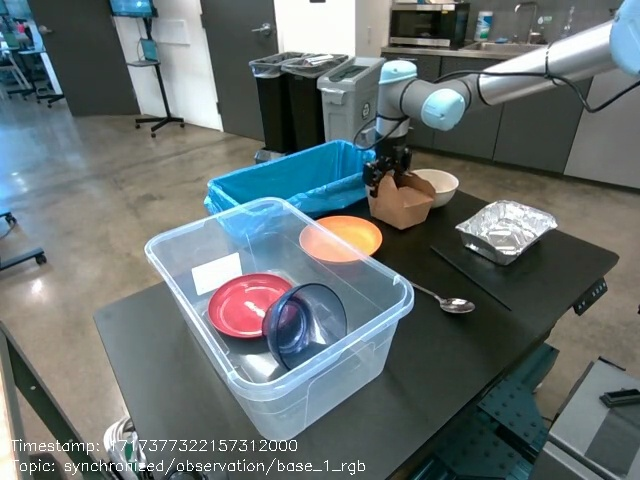

In [214]:
render_video(frames, 0)

In [215]:
start_response = await vlm_request(
        client, SYSTEM_PROMPT, start_prompt, frames, extract_json=False
    )

In [217]:
print(start_response)

[Reasoning]
- **Criterion 1:** The first image shows the robot's gripper above the table, but the `Cardboard Food Container` is still on the table. There is no significant visible gap between the table and the `Cardboard Food Container`.
- **Criterion 2:** The gripper is not actively moving towards the destination; it is still in the process of picking up the `Cardboard Food Container`.
- **Criterion 3:** The `Cardboard Food Container` is not clearly lifted off the table, as it is still in contact with the table.

Based on these criteria, the first image does not fully encapsulate the start of the action of putting the `Cardboard Food Container` into the trash bin. The first image is too early.

```json
{
"answer":"early"
}
```


In [98]:
def create_check_prompts(task_type, task_name, object_name):
    """Creating the prompt template to run the checks"""
    if task_type == "pick":
        start_prompt = CHECK_PICKUP_START_IMAGE_TIMING.format(
            action=task_name, object=object_name
        )
        end_prompt = CHECK_PICKUP_END_IMAGE_TIMING.format(
            action=task_name, object=object_name
        )
    elif task_type == "put":
        start_prompt = CHECK_DEPOSIT_START_IMAGE_TIMING.format(
            action=task_name, object=object_name
        )
        end_prompt = CHECK_DEPOSIT_END_IMAGE_TIMING.format(
            action=task_name, object=object_name
        )
    else:
        raise ValueError(f"Unsupported task type: {task_type}")
    return start_prompt, end_prompt

async def run_check(client, system_prompt, prompt, frames, extract_json):
    return await vlm_request(client, system_prompt, prompt, frames, extract_json=extract_json)

async def check_task(task, task_type, client, video_path, fps=5):
    frames, _ = adjust_fps_to_frame_count(
        video_path, task["start_image"], task["end_image"], fps, 8, 22
    )

    start_prompt, end_prompt = create_check_prompts(
        task_type, task["action"], task["object"]
    )

    start_task = asyncio.create_task(run_check(client, SYSTEM_PROMPT, start_prompt, frames, extract_json=True))
    end_task = asyncio.create_task(run_check(client, SYSTEM_PROMPT, end_prompt, frames, extract_json=True))

    start_response, end_response = await asyncio.gather(start_task, end_task)

    return {
        "task_type": task_type,
        "action": task["action"],
        "object": task["object"],
        "start_answer": start_response,
        "end_answer": end_response,
        "start_check": extract_json_from_response(start_response)["answer"],
        "end_check": extract_json_from_response(end_response)["answer"],
    }
    
async def check_object(object_tasks, client, video_path, fps=5):
    pick_up_test = object_tasks[0]
    put_test = object_tasks[1]

    pick_task = asyncio.create_task(check_task(pick_up_test, "pick", client, video_path, fps))
    put_task = asyncio.create_task(check_task(put_test, "put", client, video_path, fps))

    return await asyncio.gather(pick_task, put_task)


In [100]:
tasks = []
for object_idx, object_response in enumerate(response):
    object_tasks = object_response['tasks']
    tasks.append(check_object(object_tasks, client, VIDEO_PATH, fps))

all_results = await asyncio.gather(*tasks)

for object_idx, object_results in enumerate(all_results):
    print(f"Object {object_idx}:")
    for result in object_results:
        print(f"  Task Type: {result['task_type']}")
        print(f"  Action: {result['action']}")
        print(f"  Object: {result['object']}")
        print(f"  Start Check: {result['start_check']}")
        print(f"  End Check: {result['end_check']}")
        print("  ---")
    print("===")

Error decoding JSON or accessing response: expected string or bytes-like object


TypeError: 'NoneType' object is not subscriptable

Error decoding JSON or accessing response: expected string or bytes-like object
Error decoding JSON or accessing response: expected string or bytes-like object
Error decoding JSON or accessing response: expected string or bytes-like object
Error decoding JSON or accessing response: expected string or bytes-like object
Error decoding JSON or accessing response: expected string or bytes-like object
Error decoding JSON or accessing response: expected string or bytes-like object
Error decoding JSON or accessing response: expected string or bytes-like object
Error decoding JSON or accessing response: expected string or bytes-like object
Error decoding JSON or accessing response: expected string or bytes-like object
Error decoding JSON or accessing response: expected string or bytes-like object
Error decoding JSON or accessing response: expected string or bytes-like object
Error decoding JSON or accessing response: expected string or bytes-like object
Error decoding JSON or accessing respons

## FLOW: 
- First pass: label actions + frame numbers
- Reflection to check if object its holding is correct (maybe optional) (Reflection)
- Double click into specific frames for label 
- Reflection with loop until done. moving it back and forth

## Seperate pick and put labels

In [452]:
LABEL_PICKUP_ACTION = """
**Objective:**
Determine and report the "pick up" action and frame numbers successfully completed by a robot in a video sequence involving object {object}. There are a total of {num_frames} frames in the video. 

**Summary Criteria:**
- Focus only on the "pick up" action in this video.
- Ensure the reported action matches the visual evidence available in the video.

**Instructions for Pick up:**

**1. Start Image Criteria for Pickup:**
   - **Criterion 1:** The robot gripper should not be grasping or holding any objects, including `{object}`
   - **Criterion 2:** The gripper should be positioned away from any objects, and the following frames should capture the robot gripper moving towards the `{object}`, before it picks it up. 

**2. End Image Criteria for Pickup:**
   - **Criterion 1:** Identify the image where `{object}` is securely held by the gripper and fully lifted off the table. If `{object}` is still touching the table, select a subsequent frame.
   - **Criterion 2:** Ensure that `{object}` has not yet started moving towards the destination (bin / container). It should have just been picked up, and not yet started its trajectory towards the destination.
   - **Criterion 3:** The `{object}` should not be over the container / bin yet.

**Example Summary Report in JSON Format:**
{{
  "tasks": [
    {{
      "action": "Pick up {object}",
      "start_image_thought_process": "✓ Gripper empty: Confirmed in frame X
✓ Gripper approaching: Observed movement towards {object} in subsequent frames
✓ Space between gripper and {object}: Visible gap noted
✓ No other objects held: Verified gripper is empty",
      "end_image_thought_process": "✓ {object} securely held: Gripper closed around {object}
✓ Fully lifted: Clear space visible between {object} and table
✓ Not moving to destination: {object} position stable after lift
✓ Not over container: {object} not above final destination",
      "start_image": 2,
      "end_image": 7,
      "object": "{object}"
    }}
  ]
}}

Provide concise checklists for both start and end images of the pick up action, noting how each criterion was met.
"""

LABEL_PUT_ACTION = """
**Objective:**
Determine and report the "put" action and frame numbers successfully completed by a robot in a video sequence involving object {object}. There are a total of {num_frames} frames in the video. 

**Summary Criteria:**
- Focus only on the "put" action in this video.
- Ensure the reported action matches the visual evidence available in the video.
- Think carefully about the destination of the object.

**Instructions for Put:**

**1. Start Image Criteria for Put:**
   - **Criterion 1:** Identify the image where the robot's gripper is securely holding `{object}`, which should be elevated and not yet positioned over its final destination. If `{object}` is already positioned over the destination, select an earlier frame as the start.
   - **Criterion 2:** The gripper should be actively moving towards the destination, having just completed the pickup phase. Images where the gripper is stationary or moving away from the destination are considered too late.
   - **Criterion 3:** `{object}` must be clearly lifted off the table, ensuring visible space between the table and the object.

**2. End Image Criteria for Put:**
   - **Criterion 1:** Locate the image where the gripper has released `{object}` into its designated spot, and the object is visibly settled within the destination. If `{object}` has not been released, the frame is too early.
   - **Criterion 2:** Confirm the presence of preceding images showing `{object}` already in the destination to ensure continuity. Lack of such frames suggests the need for additional footage.
   - **Criterion 3:** Search for images showing a clear retreat of the gripper from the destination. Images where the gripper remains in contact with `{object}` are too early.

**Example Summary Report in JSON Format:**
{{
  "tasks": [
    {{
      "action": "Put {object} into container",
#       "start_image_thought_process": "✓ Gripper holding {object}: Securely grasped
# ✓ Elevated position: Clear space below {object}
# ✓ Not over destination: {object} not above container yet
# ✓ Moving towards destination: Observed directional movement",
#       "end_image_thought_process": "✓ {object} released: No contact with gripper
# ✓ Settled in destination: {object} stable in container
# ✓ Preceding frames consistent: Continuous motion observed
# ✓ Gripper retreating: Clear separation from {object}",
      "start_image": 7,
      "end_image": 10,
      "object": "{object}"
    }}
  ]
}}

Provide concise checklists for both start and end images of the put action, noting how each criterion was met. Respond in a json.
"""

In [650]:
LABEL_PICKUP_ACTION = """
**Objective:**
Determine and report the "pick up" action and frame numbers successfully completed by a robot in a video sequence involving object {object}. There are a total of {num_frames} frames in the video. 

**Summary Criteria:**
- Focus only on the "pick up" action in this video.
- Ensure the reported action matches the visual evidence available in the video.
- Ignore other objects that aren't {object}. If the frames show the robot manipulating other objects, exclude them. Your respone should include only the robot moving object {object}

**Instructions for Pick up:**

**1. Start Image Criteria for Pickup:**
   - **Criterion 1:** The robot gripper should not be grasping or holding any objects, including `{object}`
   - **Criterion 2:** The gripper should be positioned away from any objects, and the following frames should capture the robot gripper moving towards the `{object}`, before it picks it up. 

**2. End Image Criteria for Pickup:**
   - **Criterion 1:** Identify the image where `{object}` is securely held by the gripper and fully lifted off the table. If `{object}` is still touching the table, select a subsequent frame.
   - **Criterion 2:** Ensure that `{object}` has not yet started moving towards the destination (bin / container). It should have just been picked up, and not yet started its trajectory towards the destination.
   - **Criterion 3:** The `{object}` should not be over the container / bin yet.

**Example Summary Report in JSON Format:**
[Reasoning]
{{
  "tasks": [
    {{
      "action": "Pick up {object}",
      "start_image": 2,
      "end_image": 7,
      "object": "{object}"
    }}
  ]
}}

Think step by step through this, keeping strict attention to the criteria mentioned above. Think through the reasoning before answering in JSON response.
"""

LABEL_PUT_ACTION = """
**Objective:**
Determine and report the "put" action and frame numbers successfully completed by a robot in a video sequence involving object {object}. There are a total of {num_frames} frames in the video. 

**Summary Criteria:**
- Focus only on the "put" action in this video.
- Ensure the reported action matches the visual evidence available in the video.
- Think carefully about the destination of the object.
- Ignore other objects that aren't {object}. If the frames show the robot manipulating other objects, exclude them. Your respone should include only the robot moving object {object}

**Instructions for Put:**

**1. Start Image Criteria for Put:**
   - **Criterion 1:** Identify the image where the robot's gripper is securely holding `{object}`, which should be elevated and not yet positioned over its final destination. If `{object}` is already positioned over the destination, select an earlier frame as the start.
   - **Criterion 2:** The gripper should be actively moving towards the destination, having just completed the pickup phase. Images where the gripper is stationary or moving away from the destination are considered too late.
   - **Criterion 3:** `{object}` must be clearly lifted off the table, ensuring visible space between the table and the object.

**2. End Image Criteria for Put:**
   - **Criterion 1:** Locate the image where the gripper has released `{object}` into its designated spot, and the object is visibly settled within the destination. If `{object}` has not been released, the frame is too early.
   - **Criterion 2:** Confirm the presence of preceding images showing `{object}` already in the destination to ensure continuity. Lack of such frames suggests the need for additional footage.
   - **Criterion 3:** Search for images showing a clear retreat of the gripper from the destination. Images where the gripper remains in contact with `{object}` are too early.

**Example Summary Report in JSON Format:**
[Reasoning]
{{
  "tasks": [
    {{
      "action": "Put {object} into container",
      "start_image": 7,
      "end_image": 10,
      "object": "{object}"
    }}
  ]
}}

Think step by step through this, keeping strict attention to the criteria mentioned above. Think through the reasoning before answering in JSON response.
"""

## Simplified version of seperation of concerns

In [629]:
LABEL_PICKUP_ACTION = """
Objective:
Identify the start and end frames of the "pick up" action for {object} in a {num_frames}-frame video sequence.

Instructions:
1. Find the start frame where:
   - The gripper is empty and far away from any object
   - The gripper has not yet begun moving towards {object}
   - This frame should be before any approach towards {object} is visible
   Note: Be very generous with the start frame. It's better to capture more of the scene before the approach than to start too late.

2. Find the end frame where:
   - {object} is fully lifted off the table
   - {object} is securely held by the gripper
   - The gripper is not holding the {object} over its destination
   - There are at least a couple of frames showing {object} off the table
   Note: Ensure there are multiple frames showing {object} lifted before selecting the end frame.

Important:
- Focus only on {object}, ignore other objects
- Start frame should be much earlier rather than later, to capture the scene before any approach
- End frame should be the latest that meets all criteria, including multiple frames of {object} being lifted
- Frame numbers must be between 1 and {num_frames}

Before providing your answer, check each criterion:

Start frame check:
- Is the gripper empty and far away from any object? [Yes/No]
- Has the gripper not yet begun moving towards {object}? [Yes/No]
- Is this frame before any approach towards {object} is visible? [Yes/No]

End frame check:
- Is {object} fully lifted off the table? [Yes/No]
- Is {object} securely held by the gripper? [Yes/No]
- Is the gripper holding the {object} over its destination? [Yes/No]
- Are there at least a couple of frames showing {object} off the table? [Yes/No]

If all checks are "Yes", provide your answer in this JSON format:
{{
  "tasks": [
    {{
      "action": "Pick up {object}",
      "start_image": [start frame number],
      "end_image": [end frame number],
      "object": "{object}"
    }}
  ]
}}

Replace [start frame number] and [end frame number] with your chosen frame numbers.
"""

LABEL_PUT_ACTION = """
Objective:
Identify the start and end frames of the "put" action for {object} in a {num_frames}-frame video sequence.

Instructions:
1. Find the start frame where:
   - The gripper is securely holding {object}
   - {object} is clearly lifted off the table
   - The gripper starts moving {object} towards its destination

2. Find the end frame where:
   - {object} is released into its final destination
   - {object} is visibly settled in place
   - The gripper has started moving away from {object}
   Note: Be generous with the end frame. It's better to capture more of the gripper's retreat than to end too early.

Important:
- Focus only on {object}, ignore other objects
- Start frame should be the earliest that meets all criteria
- End frame should be later rather than earlier, to capture more of the gripper's retreat
- Frame numbers must be between 1 and {num_frames}
- The "put" action should start after the "pick up" action ends

Before providing your answer, check each criterion:

Start frame check:
- Is the gripper securely holding {object}? [Yes/No]
- Is {object} clearly lifted off the table? [Yes/No]
- Has the gripper started moving {object} towards its destination? [Yes/No]

End frame check:
- Has {object} been released into its final destination? [Yes/No]
- Is {object} visibly settled in place? [Yes/No]
- Has the gripper started moving away from {object}? [Yes/No]

If all checks are "Yes", provide your answer in this JSON format:
{{
  "tasks": [
    {{
      "action": "Put {object} into [destination]",
      "start_image": [start frame number],
      "end_image": [end frame number],
      "object": "{object}"
    }}
  ]
}}

Replace [start frame number], [end frame number], and [destination] with appropriate values based on your analysis.
"""

In [651]:
from IPython.display import Image, display, clear_output
import asyncio

async def process_object(obj):
    start_frame, end_frame = obj['start_frame']*3, obj['end_frame']*3
    start_frame -= 60
    end_frame += 30
    fps = 5

    frames, _ = adjust_fps_to_frame_count(
        VIDEO_PATH, start_frame, end_frame, fps, 8, 18
    )
    print(f"object {obj['object_name']} has this many frames: {len(frames)}")
    
    # Process pickup action
    pickup_prompt = LABEL_PICKUP_ACTION.format(object=obj['object_name'], num_frames=len(frames))
    pickup_answer = await vlm_request(client, SYSTEM_PROMPT, pickup_prompt, frames, extract_json=True)
    
    # Process put action
    put_prompt = LABEL_PUT_ACTION.format(object=obj['object_name'], num_frames=len(frames))
    put_answer = await vlm_request(client, SYSTEM_PROMPT, put_prompt, frames, extract_json=True)
    
    # Extract start and end images for both actions
    pick_up_start_image = pickup_answer['tasks'][0]['start_image']
    pick_up_end_image = pickup_answer['tasks'][0]['end_image']
    put_start_image = put_answer['tasks'][0]['start_image']
    put_end_image = put_answer['tasks'][0]['end_image']

    # Calculate frame numbers
    pickup_start_frame = int(start_frame) + (pick_up_start_image - 1) * 30 / fps
    pickup_end_frame = int(start_frame) + (pick_up_end_image) * 30 / fps
    put_start_frame = int(start_frame) + (put_start_image - 1) * 30 / fps
    put_end_frame = int(start_frame) + (put_end_image) * 30 / fps
    
    # Combine results
    combined_answer = {
        "tasks": [
            {**pickup_answer['tasks'][0], "start_frame": pickup_start_frame, "end_frame": pickup_end_frame},
            {**put_answer['tasks'][0], "start_frame": put_start_frame, "end_frame": put_end_frame}
        ]
    }
    
    print(combined_answer)
    
    return combined_answer

# Run the processing for all objects
async def process_all_objects():
    tasks = [process_object(obj) for obj in filtered_objects]
    responses = await asyncio.gather(*tasks)
    return responses

# Execute the processing
responses = await process_all_objects()

object bowl has this many frames: 17
object bowl has this many frames: 15
object plate has this many frames: 16
object chopstick has this many frames: 14
object spoon has this many frames: 15
object foil packet has this many frames: 18
object cardboard food container has this many frames: 13
{'tasks': [{'action': 'Pick up cardboard food container', 'start_image': 2, 'end_image': 7, 'object': 'cardboard food container', 'start_frame': 177.0, 'end_frame': 213.0}, {'action': 'Put cardboard food container into container', 'start_image': 7, 'end_image': 10, 'object': 'cardboard food container', 'start_frame': 207.0, 'end_frame': 231.0}]}
{'tasks': [{'action': 'Pick up bowl', 'start_image': 6, 'end_image': 8, 'object': 'bowl', 'start_frame': 66.0, 'end_frame': 84.0}, {'action': 'Put bowl into container', 'start_image': 6, 'end_image': 10, 'object': 'bowl', 'start_frame': 66.0, 'end_frame': 96.0}]}
{'tasks': [{'action': 'Pick up chopstick', 'start_image': 6, 'end_image': 9, 'object': 'chopsti

In [653]:
responses

[{'tasks': [{'action': 'Pick up bowl',
    'start_image': 6,
    'end_image': 10,
    'object': 'bowl',
    'start_frame': 405.0,
    'end_frame': 435.0},
   {'action': 'Put bowl into container',
    'start_image': 9,
    'end_image': 13,
    'object': 'bowl',
    'start_frame': 423.0,
    'end_frame': 453.0}]},
 {'tasks': [{'action': 'Pick up bowl',
    'start_image': 6,
    'end_image': 8,
    'object': 'bowl',
    'start_frame': 66.0,
    'end_frame': 84.0},
   {'action': 'Put bowl into container',
    'start_image': 6,
    'end_image': 10,
    'object': 'bowl',
    'start_frame': 66.0,
    'end_frame': 96.0}]},
 {'tasks': [{'action': 'Pick up plate',
    'start_image': 6,
    'end_image': 9,
    'object': 'plate',
    'start_frame': 291.0,
    'end_frame': 315.0},
   {'action': 'Put plate into container',
    'start_image': 7,
    'end_image': 12,
    'object': 'plate',
    'start_frame': 297.0,
    'end_frame': 333.0}]},
 {'tasks': [{'action': 'Pick up chopstick',
    'start_image

In [646]:
index = 2
answer = responses[index]

In [647]:
answer

{'tasks': [{'action': 'Pick up plate',
   'start_image': 1,
   'end_image': 10,
   'object': 'plate',
   'start_frame': 261.0,
   'end_frame': 321.0},
  {'action': 'Put plate into box',
   'start_image': 8,
   'end_image': 13,
   'object': 'plate',
   'start_frame': 303.0,
   'end_frame': 339.0}]}

In [648]:
pick_up_frames = extract_frames_from_video(VIDEO_PATH, answer['tasks'][0]['start_frame'], answer['tasks'][0]['end_frame'], fps=30)
put_frames = extract_frames_from_video(VIDEO_PATH, answer['tasks'][1]['start_frame'], answer['tasks'][1]['end_frame'], fps=30)

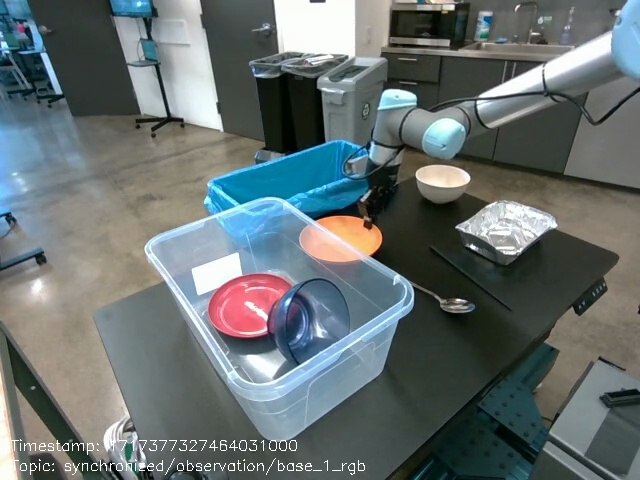

In [649]:
render_video(pick_up_frames)

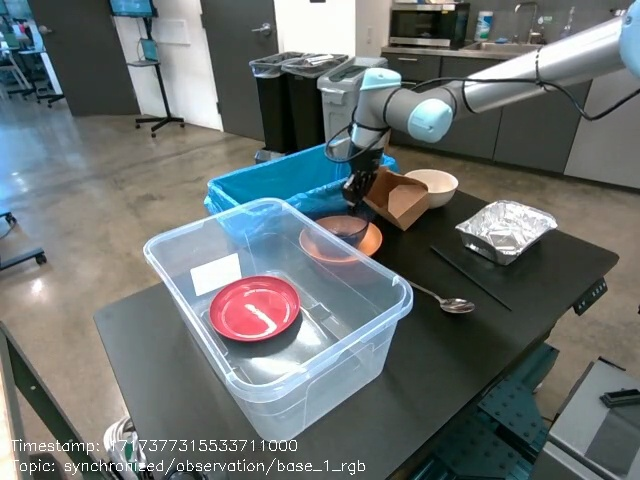

In [645]:
render_video(put_frames)

In [24]:

def extract_frames_from_video(video_path, start_frame, end_frame, fps=10):
    base64Frames = []
    video = cv2.VideoCapture(video_path)
    video_fps = video.get(cv2.CAP_PROP_FPS)

    frames_to_skip = max(int(video_fps / fps), 1)
    curr_frame = start_frame

    while curr_frame < end_frame:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip

    video.release()

    return base64Frames


    
async def vlm_request(
    client, system_prompt, prompt, frames, temperature=0, extract_json=True
):

    messages = [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                "These are a sequence of images from the video. The first image is the start image, and the final image is the end image.",
                *map(
                    lambda x: {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpg;base64,{x}",
                            "detail": "high",
                        },
                    },
                    frames,
                ),
                prompt,
            ],
        },
    ]

    response = await client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=temperature,
    )

    response = response.choices[0].message.content

    if extract_json:
        response = extract_json_from_response(response)

    return response


def adjust_fps_to_frame_count(
    video_path, segment_start, segment_end, initial_fps, min_frames, max_frames
):
    """
    Adjust the frames per second (fps) to ensure the number of frames lies within a specified range.
    """
    
    sequence_fps = initial_fps
    fps_options = [1,2,3, 5, 10]
    while True:
        frames = extract_frames_from_video(
            video_path,
            start_frame=segment_start,
            end_frame=segment_end,
            fps=sequence_fps,
        )
        num_images = len(frames)

        if num_images < min_frames:
            # Increase fps to the next higher option if below the minimum frame count
            current_index = fps_options.index(sequence_fps)
            if current_index < len(fps_options) - 1:
                sequence_fps = fps_options[current_index + 1]
            else:
                # If already at max fps and frames are still not enough, use the highest possible fps
                break
        elif num_images > max_frames:
            # Decrease fps to the next lower option if above the maximum frame count
            current_index = fps_options.index(sequence_fps)
            if current_index > 0:
                sequence_fps = fps_options[current_index - 1]
            else:
                # If already at minimum fps and frames are still too many, use the lowest possible fps
                break
        else:
            # If the number of frames is within the acceptable range, stop adjusting
            break

    return frames, sequence_fps

In [ ]:

async def label_actions_in_episode(
    client, video_path, moved_objects, video_chunks, fps=1
):
    """Labeling which actions took place for each video chunk in an episode"""
    tasks = []
    for (start, end), change in zip(video_chunks, moved_objects):
        if change:
            moved_objects_string = ", ".join(change["moved_objects"])
            label_action_prompt = LABEL_ACTIONS.format(
                moved_objects=moved_objects_string
            )

            frames, fps = adjust_fps_to_frame_count(video_path, start, end, fps, 8, 22)
            # extract_frames_from_video(video_path, start, end, fps=fps)
            task = vlm_request(
                client,
                SYSTEM_PROMPT,
                label_action_prompt,
                frames,
                extract_json=True,
            )
            tasks.append(task)
    labeled_actions = await asyncio.gather(*tasks)

    actions_with_frame_ranges = []
    for (start_segment_frame, _), response in zip(video_chunks, labeled_actions):
        for action_dict in response["tasks"]:
            start_image_number, end_image_number = (
                int(action_dict["start_image"]),
                int(action_dict["end_image"]),
            )
            start_frame = int(start_segment_frame) + (start_image_number - 1) * 30 / fps
            end_frame = int(start_segment_frame) + (end_image_number) * 30 / fps
            action_dict.update(
                {
                    "start_frame": start_frame,
                    "end_frame": end_frame,
                    "start_image": start_image_number,
                    "end_image": end_image_number,
                    "fps": fps,
                }
            )
            action_dict = add_action_type(action_dict)
            actions_with_frame_ranges.append(action_dict)

    return actions_with_frame_ranges